### Лабораторная работа №2
## Рекомендательные системы


In [1]:
%%capture
!pip install pandas
# !pip install feedparser transformers hf_xet plotly nbformat ipython ipywidgets ipykernel jupyterlab_widgets2

In [2]:
# import feedparser
# import urllib.request as libreq
# import urllib.parse
# import requests
import pandas as pd

1. Выбрать датасет, подходящий для моделирования рекомендательной системы.  Хорошие источники данных: https://ods.ai/competitions/ и https://www.recsyschallenge.com/2025/ (тут можно подставлять любой год, начиная с 2016). Ещё примеры данных: https://www.aicrowd.com/challenges/spotify-million-playlist-dataset-challenge#dataset и https://boosters.pro/championship/rekko_challenge/data. Не рекомендуется брать данные с Kaggle, так как по ним часто уже есть готовый EDA и baseline. Запрещено брать датасет Movielens (любого размера).

Выбрал Avito Tech ML CUP 2025

clickstream.pq - история взаимодействия пользователей с объявлениями
- cookie - id пользователя [int64]
- item - id объявления [int64]
- event - id тип события [int64]. Например “клик”, “показать телефон”, “написать в мессенджер”
- event_date - время, когда пользователь провзаимодействовал с айтемом datetime[ns]
- surface  - экран, с которого было взаимодействие. Например пользователь может взаимодействовать с айтемом на поисковой выдаче, во вкладке “Избранное” [int64]
- platform -  тип устройства, с которого пользователь совершил действие. Например - android, ios, desktop, браузер в телефоне [int64]
- node - id группы товара [int64]

In [3]:
df_full = pd.read_parquet("data/lab-2/avito/clickstream.pq")
df_full.head()

,cookie,item,event,event_date,platform,surface,node
0,0,19915558,17,2025-02-05 02:30:59,3,2,115659
1,0,2680232,17,2025-01-24 21:16:57,3,2,115829
2,1,4247649,17,2025-01-29 23:00:58,2,2,7
3,1,4247649,17,2025-02-17 14:55:17,2,2,7
4,1,2171135,17,2025-01-17 19:23:29,2,2,214458


Засемплировал

In [4]:
df = df_full
users = df["cookie"].drop_duplicates().sample(frac=0.01, random_state=42)
df = df[df["cookie"].isin(users)].reset_index(drop=True)
df.shape

(690352, 7)

Разделил на train и test

In [5]:
from datetime import timedelta
EVAL_DAYS_TRESHOLD = 14
treshold = df['event_date'].max() - timedelta(days=EVAL_DAYS_TRESHOLD)
df_train = df[df['event_date'] <= treshold]
df_test = df[df['event_date'] > treshold][['cookie', 'node', 'event']]
df_train.shape

(463170, 7)

2. Сделать разведочный анализ данных (EDA), то есть посчитать статистические показатели, построить визуализации и дать им интерпретацию, подготовить отчёт по качеству данных (пропуски, дубли, выбросы). При необходимости предобработать данные. Сделать выводы. 

- cookie - id пользователя [int64]
- item - id объявления [int64]
- event - id тип события [int64]. Например “клик”, “показать телефон”, “написать в мессенджер”
- event_date - время, когда пользователь провзаимодействовал с айтемом datetime[ns]
- surface  - экран, с которого было взаимодействие. Например пользователь может взаимодействовать с айтемом на поисковой выдаче, во вкладке “Избранное” [int64]
- platform -  тип устройства, с которого пользователь совершил действие. Например - android, ios, desktop, браузер в телефоне [int64]
- node - id группы товара [int64]

In [6]:
%%capture
!pip install numpy

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = df_train

print("Размер данных:", df.shape)
print("\nИнформация о типах:")
print(df.info())


Размер данных: (463170, 7)

Информация о типах:
<class 'pandas.core.frame.DataFrame'>
Index: 463170 entries, 0 to 690351
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   cookie      463170 non-null  int64         
 1   item        463170 non-null  int64         
 2   event       463170 non-null  int64         
 3   event_date  463170 non-null  datetime64[ns]
 4   platform    463170 non-null  int64         
 5   surface     463170 non-null  int64         
 6   node        463170 non-null  uint32        
dtypes: datetime64[ns](1), int64(5), uint32(1)
memory usage: 26.5 MB
None


### Проверка пропусков и дубликатов

In [25]:
missing = df.isna().sum().sort_values(ascending=False)
print("Пропущенные значения:")
print(missing[missing > 0])

dupes = df.duplicated().sum()
print(f"Количество полных дубликатов: {dupes}")

Пропущенные значения:
Series([], dtype: int64)
Количество полных дубликатов: 2545


Данные пригодны для анализа, необходимо только избавиться от небольшого числа дубликатов, а также привести типы, поскольку числа используются для обозначения категории.

In [26]:
df = df.drop_duplicates()
df["event_date"] = pd.to_datetime(df["event_date"], errors="coerce")
for col in df.columns:
    if col != "event_date":
        df[col] = df[col].astype("category")

C:\Users\niken\AppData\Local\Temp\ipykernel_24056\695820033.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["event_date"] = pd.to_datetime(df["event_date"], errors="coerce")
C:\Users\niken\AppData\Local\Temp\ipykernel_24056\695820033.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype("category")


### Диапазон дат

In [27]:
print("Минимальная дата:", df["event_date"].min())
print("Максимальная дата:", df["event_date"].max())

Минимальная дата: 2025-01-10 00:00:01
Максимальная дата: 2025-02-08 23:59:59


### Уникальные значения

In [28]:
cat_cols = [c for c in df.columns if c != "event_date"]

for col in cat_cols:
    print(f"{col}: {df[col].nunique()}")

cookie: 1270
item: 304837
event: 16
platform: 6
surface: 17
node: 40725


### Распределение событий по дате

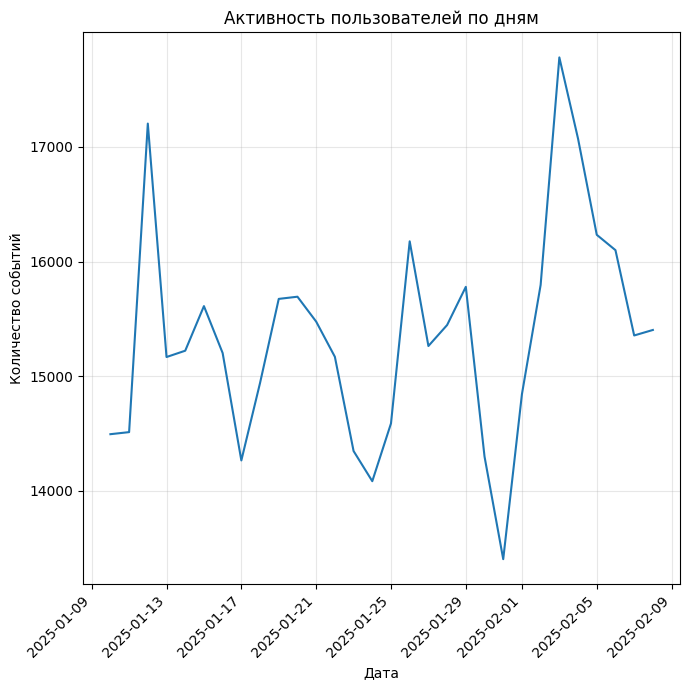

In [29]:
daily = df.set_index("event_date").resample("D").size()

plt.figure(figsize=(7, 7))
plt.plot(daily.index, daily.values, linewidth=1.5)
plt.title("Активность пользователей по дням")
plt.xlabel("Дата")
plt.ylabel("Количество событий")
plt.xticks(rotation=45, ha='right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Распределение по времени суток и дню недели

C:\Users\niken\AppData\Local\Temp\ipykernel_24056\2141842468.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hour"] = df["event_date"].dt.hour.map(day_map)
C:\Users\niken\AppData\Local\Temp\ipykernel_24056\2141842468.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["weekday"] = df["event_date"].dt.dayofweek


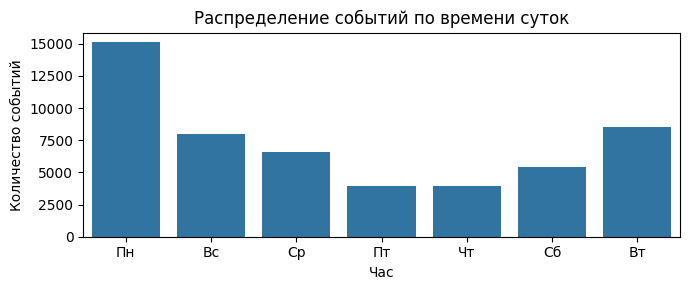

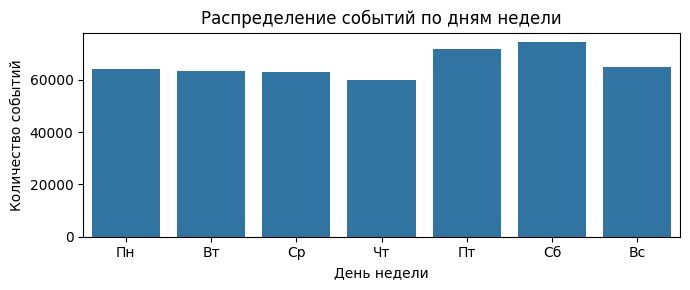

In [36]:
df["hour"] = df["event_date"].dt.hour.map(day_map)
df["weekday"] = df["event_date"].dt.dayofweek

plt.figure(figsize=(7, 3))
sns.countplot(x="hour", data=df)
plt.title("Распределение событий по времени суток")
plt.xlabel("Час")
plt.ylabel("Количество событий")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 3))
sns.countplot(x="weekday", data=df)
plt.title("Распределение событий по дням недели")
plt.xlabel("День недели")
plt.ylabel("Количество событий")
weekday_labels = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
plt.xticks(ticks=range(7), labels=weekday_labels)
plt.tight_layout()
plt.show()


### Частоты

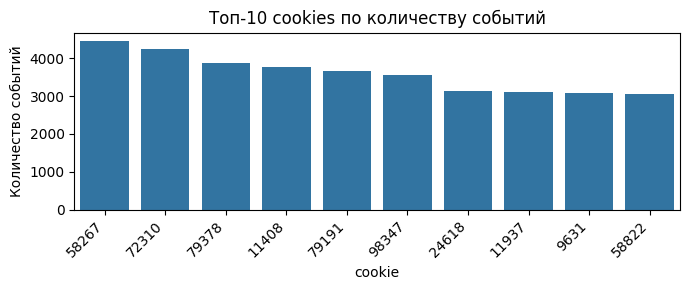

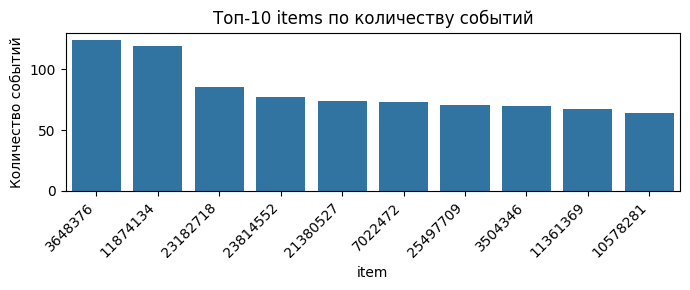

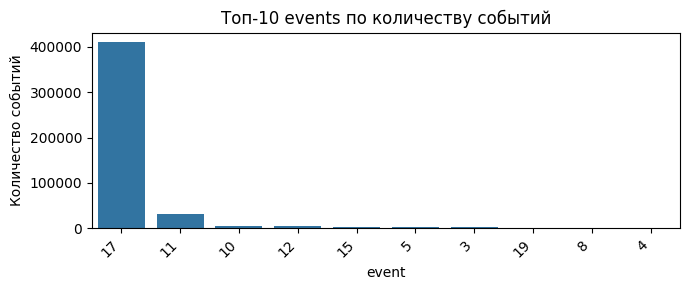

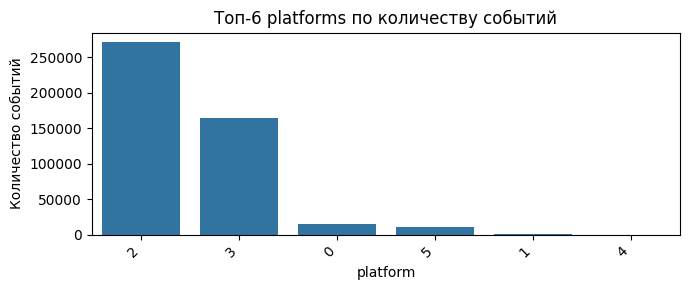

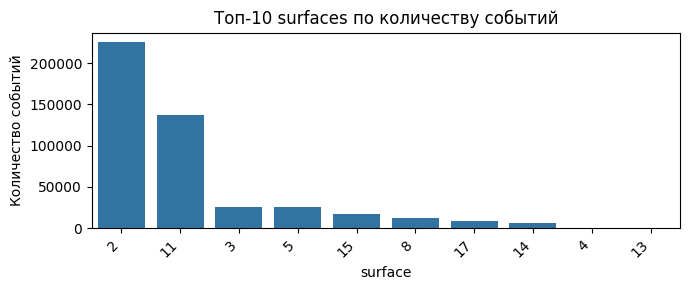

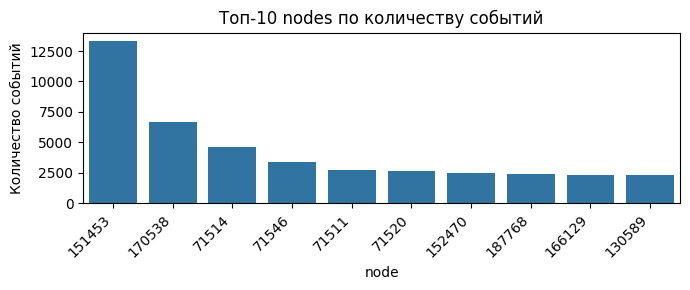

In [37]:
for col in cat_cols:
    top_vals = df[col].value_counts().head(10)
    plt.figure(figsize=(7, 3))
    sns.barplot(x=top_vals.index.astype(str), y=top_vals.values)
    plt.title(f"Топ-{min(10, len(top_vals))} {col}s по количеству событий")
    plt.xlabel(col)
    plt.ylabel("Количество событий")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

### Активность пользователей

C:\Users\niken\AppData\Local\Temp\ipykernel_24056\3083658712.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  events_per_cookie = df.groupby("cookie").size()


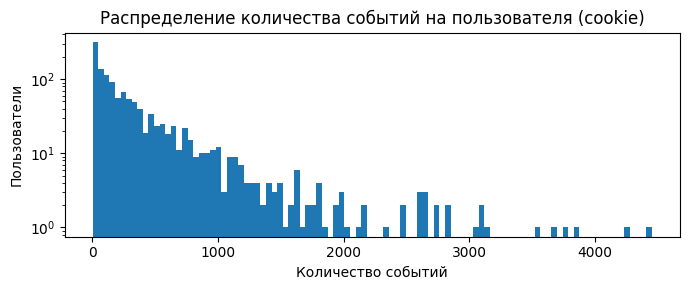


Статистика по активности пользователей:
count    1270.000000
mean      362.696850
std       536.724075
min         1.000000
50%       166.000000
90%       919.300000
95%      1338.100000
99%      2751.790000
max      4455.000000
dtype: float64


In [42]:
events_per_cookie = df.groupby("cookie").size()

plt.figure(figsize=(7, 3))
plt.hist(events_per_cookie, log=True, bins=100)
plt.title("Распределение количества событий на пользователя (cookie)")
plt.xlabel("Количество событий")
plt.ylabel("Пользователи")
plt.tight_layout()
plt.show()

print("\nСтатистика по активности пользователей:")
print(events_per_cookie.describe(percentiles=[0.5, 0.9, 0.95, 0.99]))


Большинство пользователей совершают небольшое число взаимодействий, но небольшая доля очень активных пользователей создаёт значительный объём событий и очень сильно влияет на статитстику (скорее всего боты).
Медиана (166 событий) более чем в два раза ниже среднего (363), что говорит о несимметричности распределения.
Пользователи с количеством событий выше 2750 (1% выборки) можем рассматривать как выбросы.

### Проверка на выбросы по активности

Используем метод межквартильного размаха и построим boxplot.

Ящик:
- Нижняя граница = 25-й перцентиль (Q1)
- Верхняя граница = 75-й перцентиль (Q3)

Линия внутри ящика = медиана (50-й перцентиль)

Усы:
- Нижний = Q1 − 1.5*IQR
- Верхний = Q3 + 1.5*IQR

Круги — выбросы.


Выбросов по активности пользователей: 101 (7.95%)


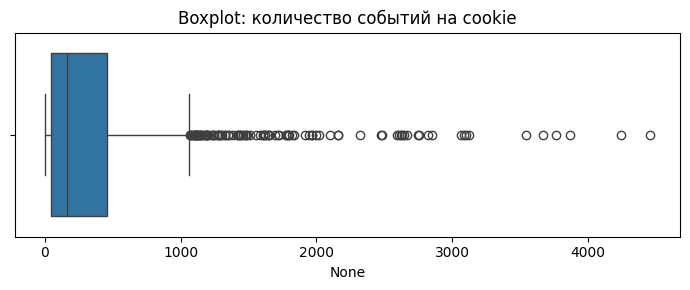

In [39]:
q1 = events_per_cookie.quantile(0.25)
q3 = events_per_cookie.quantile(0.75)
iqr = q3 - q1
upper_bound = q3 + 1.5 * iqr
outliers = events_per_cookie[events_per_cookie > upper_bound]
print(f"\nВыбросов по активности пользователей: {len(outliers)} ({len(outliers)/len(events_per_cookie)*100:.2f}%)")

plt.figure(figsize=(7, 3))
sns.boxplot(x=events_per_cookie)
plt.title("Boxplot: количество событий на cookie")
plt.tight_layout()
plt.show()



Большая часть пользователей находится внизу (до ~1000 событий).
Есть длинный «хвост» справа с пользователями, которые создают сильное смещение распределения вправо.

### Матрица корреляции (числовая кодировка категорий)

Преобразуем категориальные признаки в числовые коды для визуализации корреляции (не отражает реальную зависимость категориальных признаков, потому что коды — произвольные числа, не имеющие количественного смысла, используем её только для приблизительной визуальной оценки (наличие дублирующих признаков)).

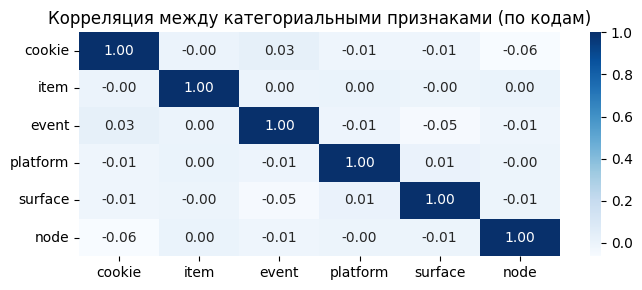

In [43]:
corr = df[cat_cols].corr()

plt.figure(figsize=(7, 3))
sns.heatmap(corr, annot=True, cmap="Blues", fmt=".2f")
plt.title("Корреляция между категориальными признаками (по кодам)")
plt.tight_layout()
plt.show()

Заметно отсутствие визуальной корреляции, исходя из чего можно сделать вывод об отсутствии дублирующих признаков.

### Итог

In [41]:
print("Строк:", len(df))
print("Пропусков:", df.isna().sum().sum())
print("Дубликатов:", dupes)
print("Диапазон дат:", df['event_date'].min(), "—", df['event_date'].max())
print("Выбросов по активности:", len(outliers))

Строк: 460625
Пропусков: 409141
Дубликатов: 2545
Диапазон дат: 2025-01-10 00:00:01 — 2025-02-08 23:59:59
Выбросов по активности: 101


3. Выбрать минимум три метода формирования рекомендации. Реализовать их. Рекомендуемые методы: MostPop, UserKNN, ItemKNN, SLIM, EASE, ALS. При выборе методов старайтесь брать методы из разных семейств. 

4. Выбрать не менее трёх метрик оценки качества рекомендаций. Рассчитать их. Желательно выбирать хотя бы одну метрику, учитывающую качество ранжирования. Желательно выбрать хотя бы одну специфическую для рекомендательных систем метрику (новизна, разнообразие, неожиданность).

5. Сформулировать предложения по улучшению качества рекомендаций. Сделать выводы.